In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn import metrics
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style()

In [2]:
def preprocess(data, scales=None):
    # Filling missing values with median
    data["Age"] = data["Age"].fillna(data["Age"].median())
    data["Fare"] = data["Fare"].fillna(data["Fare"].median())
    # Filling missing embarked with C
    data["Embarked"] = data["Embarked"].fillna("C")
    # Creating family feature
    data["Family"] = data["SibSp"] + data["Parch"]
    # Alone feature
    data["Alone"] = (data["Family"] == 0).astype(int)
    # Creating title feature
    data["Title"] = data["Name"].str.extract(r'([A-Za-z]*[.])')
    data["Title"].replace(to_replace=["Dona.", "Dr.", "Rev.", "Col.", "Mlle.", "Major.", "Countess.", "Lady.", "Don.", "Mme.", "Sir.", "Jonkheer.", "Capt.", "Ms."], value="Other.", inplace=True)

    # One hot encode categorical data (class, embarked, title and sex)
    data["Sex"] = pd.get_dummies(data["Sex"])
    data = pd.concat([data, pd.get_dummies(data["Pclass"], prefix='Class')], axis=1)
    data = pd.concat([data, pd.get_dummies(data["Embarked"], prefix='Embarked')], axis=1)
    data = pd.concat([data, pd.get_dummies(data["Title"], prefix='Title')], axis=1)
    
    # Dropping useless columns
    data.drop(columns=[
        'Name',
        'SibSp',
        'Parch',
        'Pclass',
        'Ticket',
        'Embarked',
        'Title',
        'Cabin'], inplace=True)

    # Normalizing data
    if (scales == None):
        scales = {}
    cols = list(data.columns)
    if ("Survived" in cols):
        cols.remove("Survived")
    cols.remove("PassengerId")
    for column in cols:
        if (not column in scales):
            scales[column] = {'mean': data[column].mean(), 'std': data[column].std()}
        data[column] -= scales[column]['mean']
        data[column] /= scales[column]['std']

    return scales, data

In [3]:
train_data = pd.read_csv("train.csv")

scales, train_data = preprocess(train_data)
print(train_data.head())
# Get features and targets
train_data = train_data.dropna()
targets = train_data["Survived"].values
train_data.drop(columns=["Survived", "PassengerId"], inplace=True)
features = train_data.values
print(targets.shape, features.shape)

   PassengerId  Survived       Sex       Age      Fare    Family     Alone  \
0            1         0 -0.737281 -0.565419 -0.502163  0.059127 -1.230954   
1            2         1  1.354813  0.663488  0.786404  0.059127 -1.230954   
2            3         1  1.354813 -0.258192 -0.488580 -0.560660  0.811467   
3            4         1  1.354813  0.433068  0.420494  0.059127 -1.230954   
4            5         0 -0.737281  0.433068 -0.486064 -0.560660  0.811467   

    Class_1   Class_2   Class_3  Embarked_C  Embarked_Q  Embarked_S  \
0 -0.565368 -0.509865  0.902081   -0.485303    -0.30739    0.618959   
1  1.766775 -0.509865 -1.107304    2.058256    -0.30739   -1.613803   
2 -0.565368 -0.509865  0.902081   -0.485303    -0.30739    0.618959   
3  1.766775 -0.509865 -1.107304   -0.485303    -0.30739    0.618959   
4 -0.565368 -0.509865  0.902081   -0.485303    -0.30739    0.618959   

   Title_Master.  Title_Miss.  Title_Mr.  Title_Mrs.  Title_Other.  
0      -0.216681    -0.506371   0.8

In [4]:
print(features)
print(targets)

[[-0.73728105 -0.5654189  -0.50216314 ...  0.85005432 -0.40373535
  -0.17667747]
 [ 1.35481262  0.66348839  0.78640362 ... -1.17507509  2.4740902
  -0.17667747]
 [ 1.35481262 -0.25819208 -0.48857985 ... -1.17507509 -0.40373535
  -0.17667747]
 ...
 [ 1.35481262 -0.10457867 -0.1761643  ... -1.17507509 -0.40373535
  -0.17667747]
 [-0.73728105 -0.25819208 -0.04435613 ...  0.85005432 -0.40373535
  -0.17667747]
 [-0.73728105  0.20264816 -0.49210144 ...  0.85005432 -0.40373535
  -0.17667747]]
[0 1 1 1 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 1 0 1 1 1 0 1 0 0 1 0 0 1 1 0 0 0 1
 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0
 1 0 0 0 1 1 0 1 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0
 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1
 0 1 1 0 0 1 0 1 1 1 1 0 0 1 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 1 1 0 1 0 1 0
 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 

In [5]:
test_prop = int(features.shape[0] / 5)
x_train = features[:test_prop]
y_train = targets[:test_prop]
x_test = features[-test_prop:]
y_test = targets[-test_prop:]

## Keras logistic regression

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 17        
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
446/446 [==============================] - 0s 1ms/step - loss: 0.6583 - binary_accuracy: 0.6184 - val_loss: 0.5063 - val_binary_accuracy: 0.8146
Epoch 2/20
446/446 [==============================] - 0s 755us/step - loss: 0.5057 - binary_accuracy: 0.7879 - val_loss: 0.4164 - val_binary_accuracy: 0.8820
Epoch 3/20
446/446 [==============================] - 0s 726us/step - loss: 0.4595 - binary_accuracy: 0.8182 - val_loss: 0.3842 - val_binary_accuracy: 0.8708
Epoch 4/20
446/446 [==============================] - 0s 706us/step - loss: 0.4406 - binary_accuracy: 0.8227 - val_loss: 0.3684 - val_binary_accuracy: 0.8708
Epoch 5/20
446/446 [====

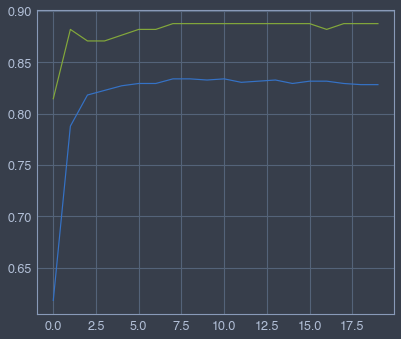

In [6]:
# Create a model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1, activation='sigmoid', input_shape=(features.shape[1],)),
#     tf.keras.layers.Dense(1, activation='sigmoid'),
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model.summary()
history = model.fit(x=features, y=targets, batch_size=2, epochs=20, shuffle=True, validation_data=(x_test, y_test))
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.show()

## Sklearn Random Forest Classifier

Accuracy: 81.46%


<AxesSubplot:ylabel='feature'>

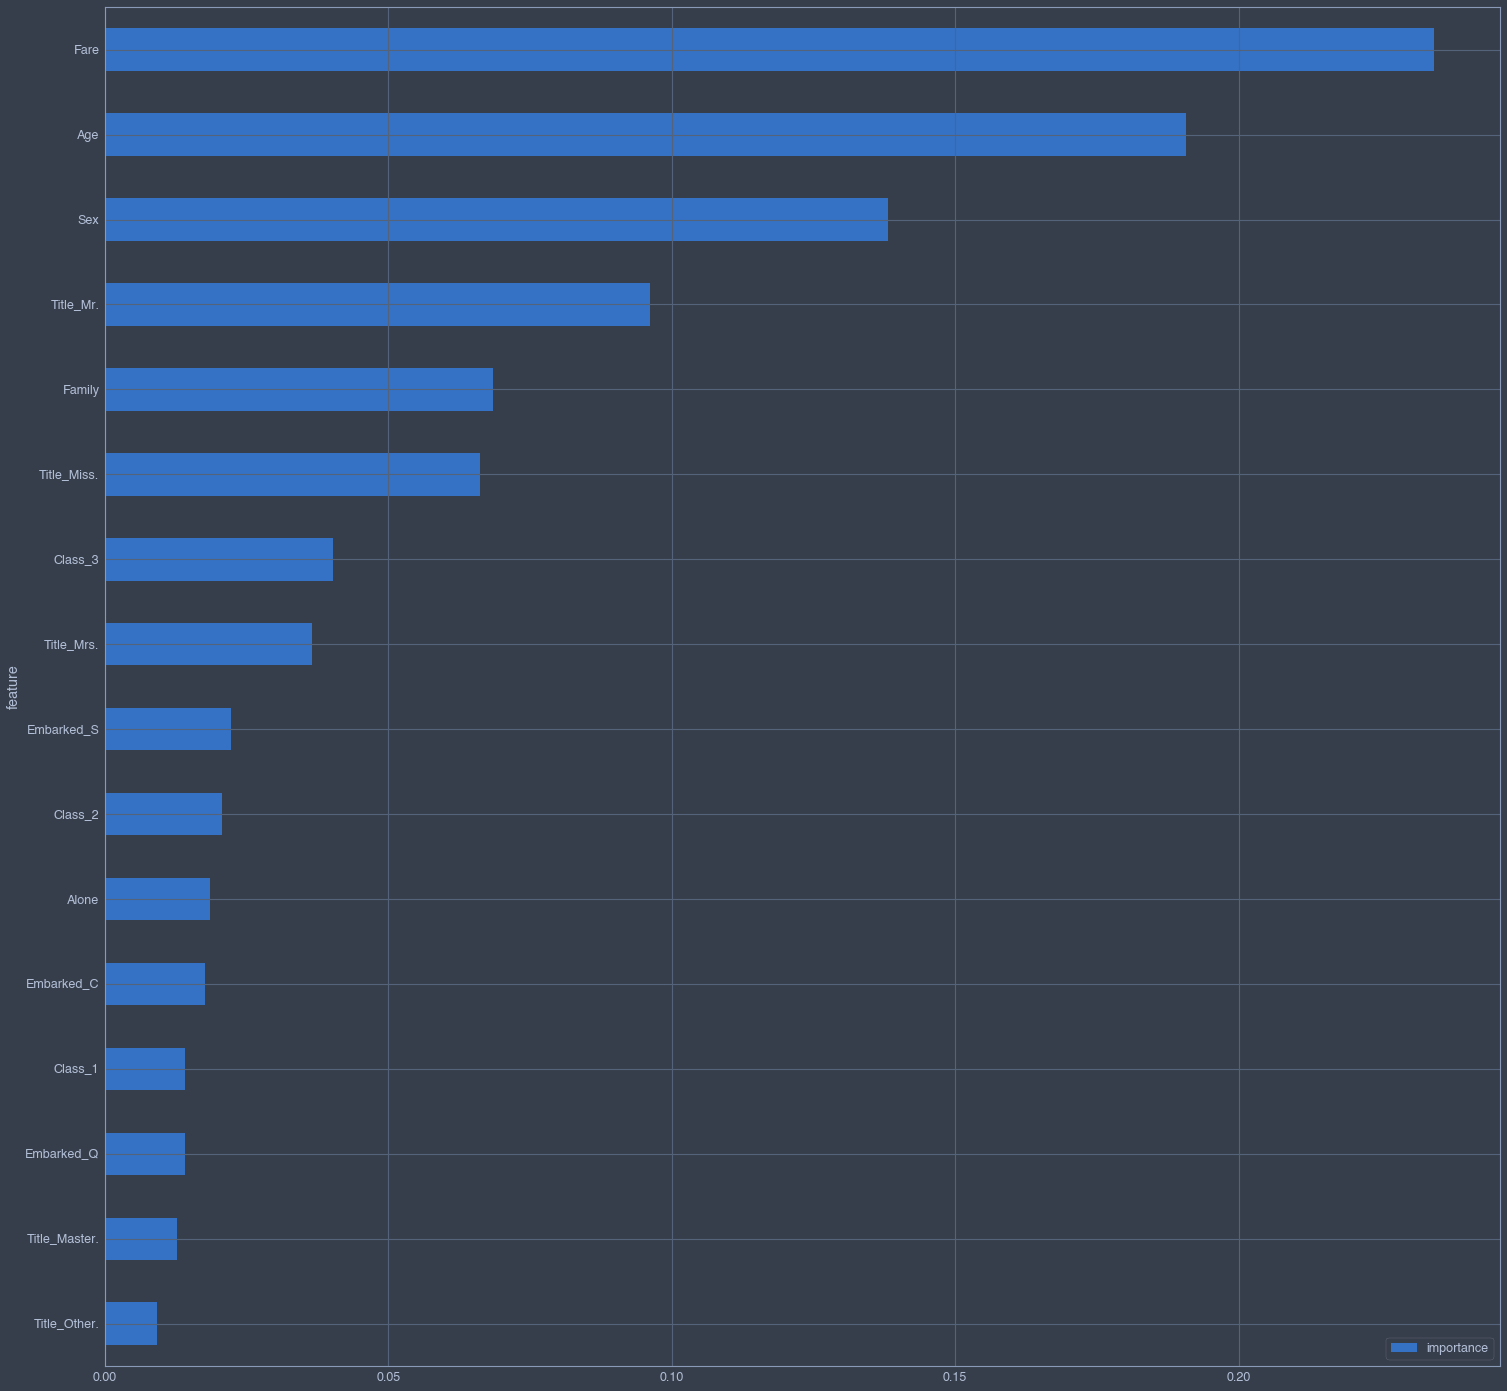

In [7]:
clf = RandomForestClassifier(n_estimators=100)
clf = clf.fit(x_train, y_train)
y_pred=clf.predict(x_test)
print("Accuracy: {:.2f}%".format(metrics.accuracy_score(y_pred, y_test) * 100))
features = pd.DataFrame()
features['feature'] = train_data.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(25, 25))

## Sklearn logistic regression

In [8]:
logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)
y_pred = logisticRegr.predict(x_test)
print("Accuracy: {:.2f}%".format(metrics.accuracy_score(y_pred, y_test) * 100))

Accuracy: 84.83%


## Predicting the test set

In [9]:
MODEL = logisticRegr

test_data = pd.read_csv("test.csv")
_, test_data = preprocess(test_data, scales=scales)

test_without_id = test_data.drop(columns=["PassengerId"])
prediction = MODEL.predict(test_without_id.values) >= 0.5
prediction = prediction.astype(int)

test_data["Survived"] = prediction
cols = list(test_data.columns)
cols.remove("PassengerId")
cols.remove("Survived")
test_data.drop(columns=cols, inplace=True)

In [10]:
test_data.to_csv('result.csv', index=False)